In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from astropy.table import Table

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']


Populating the interactive namespace from numpy and matplotlib


In [2]:
ls ../data/

61_Aqr_all_o1_sub1.png
61_Aqr_halo_lc_o1.fits
EPIC_211309989_mast.fits
EPIC_249706694_mast.fits
hlsp_halo_k2_llc_205919060_-c3_kepler_v1_lc.fits
hlsp_halo_k2_llc_205919060_-c3_kepler_v1_lc.pdf
hlsp_halo_k2_llc_205919060_-c3_kepler_v1_lc.png
ktwo200007768-c04_lpd-targ.fits.gz
ktwo200128910-c111_lpd-targ.fits.gz
ktwo200147465-c112_lpd-targ.fits.gz
ktwo200147465-c112_spd-targ.fits.gz
ktwo200173843-c13_lpd-targ.fits
ktwo201367065-c01_lpd-targ.fits.gz
ktwo205897543-c03_lpd-targ.fits.gz
ktwo205919060-c03_lpd-targ.fits.gz
ktwo211309989-c05_llc.fits
ktwo211309989-c05_lpd-targ.fits.gz
ktwo249706694-c15_llc.fits
ktwo249706694-c15_lpd-targ.fits.gz
nuInd/


In [3]:
fname = "../data/ktwo200173843-c13_lpd-targ.fits" # aldebaran


In [4]:
tpf = halo_tpf(fname)

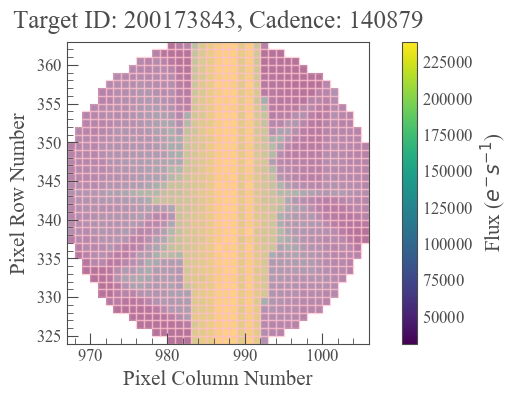

In [5]:
tpf.plot(frame=1,aperture_mask=tpf.pipeline_mask)

In [6]:
lc = tpf.to_lightcurve()
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header


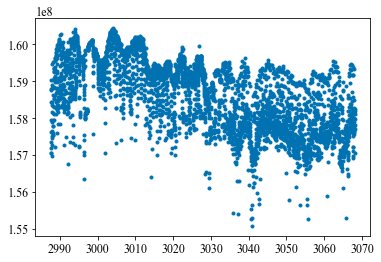

In [7]:
plt.plot(lc.time, lc.flux,'.')


## Now to do Halophot


In [8]:
tpf = halo_tpf(fname)

In [22]:
%%time
meta, corr_lc = tpf.halo(split_times=[3010],thresh=0.5);
weightmap = meta['weightmap'][0]

Taking cadences from beginning to 1042
620 saturated pixels
Throwing out 1 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Taking cadences from 1042 to end
639 saturated pixels
Throwing out 2 bad cadences
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 7.9 s, sys: 1.32 s, total: 9.22 s
Wall time: 2.58 s


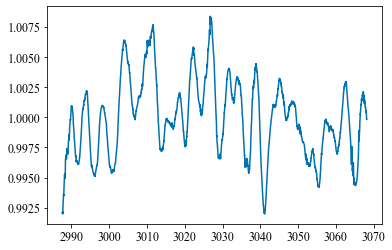

In [23]:
plt.plot(corr_lc.time,corr_lc.flux)

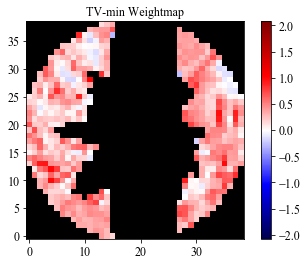

In [24]:
cmap = mpl.cm.seismic
norm = np.size(weightmap)
cmap.set_bad('k',1.)
im = np.log10(weightmap.T*norm)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title('TV-min Weightmap')
plt.savefig('aldebaran_weightmap.png')

In [25]:
from astropy.io import fits

In [13]:
f = fits.PrimaryHDU(weightmap)

In [14]:
f.writeto('aldebaran_weightmap.fits',overwrite=True)

### Now let's try and correct it with k2sc

In [26]:
import k2sc
from k2sc import standalone

corr_lc.__class__ = standalone.k2sc_lc

In [27]:
corr_lc.k2sc()

Using default splits [2998, 3033] for campaign 13
Starting initial outlier detection
  Flagged 0 ( 0.0%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    5.75 (fap 5.3813e-182 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -5410.429550665155
  DE iteration %3i -ln(L) %4.1f 1 -5460.345440572289
  DE iteration %3i -ln(L) %4.1f 2 -5460.345440572289
  DE iteration %3i -ln(L) %4.1f 3 -5460.345440572289
  DE iteration %3i -ln(L) %4.1f 4 -5460.345440572289
  DE iteration %3i -ln(L) %4.1f 5 -5460.345440572289
  DE iteration %3i -ln(L) %4.1f 6 -5507.738281588494
  DE iteration %3i -ln(L) %4.1f 7 -5553.878654548892
  DE iteration %3i -ln(L) %4.1f 8 -5553.878654548892
  DE iteration %3i -ln(L) %4.1f 9 -5553.878654548892
  DE iteration %3i -ln(L) %4.1f 10 -5553.878654548892
  DE iteration %3i -ln(L) %4.1f 11 -5553.878654548892
  DE iteration %3i -ln(L) %4.1f 12 -

Text(0.5, 1.01, 'Aldebaran')

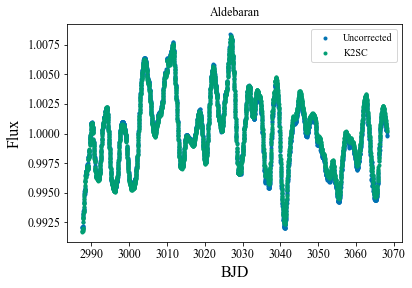

In [28]:
plt.plot(corr_lc.time,corr_lc.flux,'.',label="Uncorrected")
plt.plot(corr_lc.time,corr_lc.corr_flux,'.',label="K2SC")
plt.legend()
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.title('Aldebaran',y=1.01)